In [47]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from numba import jit
from helper import get_extention_tag, display_images
from config import base_dir

In [44]:
filenames = [f for f in os.listdir(base_dir) if get_extention_tag(f) == 'tif']
paths = [base_dir + f for f in filenames]
source_images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths]
color_images = [cv2.imread(path) for path in paths]

In [ ]:

"""
基準点からみて、明⇒暗になっている領域のマスクを作る
"""
@jit(nopython=True)
def normalize(x, y):
    r = np.sqrt(x * x + y * y)
    return x / r, y / r

@jit(nopython=True)
def validate(x, begin_x, end_x):
    return begin_x <= x and x < end_x

@jit(nopython=True)
def calculate_diff(image, given_mask, sobel_vertical, sobel_horizontal, cx, cy, thresh, vicinity_range):
    mask = np.zeros(image.shape, dtype='float32')
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if (given_mask[y, x] == 0):
                continue
            # 微分フィルタ vertical, horizontal。sovel, prewidge?
            vertically_filtered = sobel_vertical[y, x]
            horizontally_filtered = sobel_horizontal[y, x]

            # 基準点を原点とみなした座標系において処理
            # y軸近傍の点を処理。
            if (abs(x - cx) < vicinity_range):
                if (y > cy and vertically_filtered < 0 and abs(vertically_filtered) > thresh):
                    mask[y, x] = 1
                if (y < cy and vertically_filtered > 0 and abs(vertically_filtered) > thresh):
                    mask[y, x] = 1
            # x軸近傍の点を処理
            if (abs(y - cy) < vicinity_range):
                if (x > cx and horizontally_filtered < 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
                if (x < cx and horizontally_filtered > 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
            
            # 軸から離れた点を象限ごとに処理。とくに影響がないので、簡便のために軸近傍の処理と重複を許す。
            if x > cx and y > cy:
                if (vertically_filtered < 0 and abs(vertically_filtered) > thresh) and (horizontally_filtered < 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
            if (x < cx and y > cy):
                if (vertically_filtered < 0 and abs(vertically_filtered) > thresh) and (horizontally_filtered > 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
            if (x < cx and y < cy):
                if (vertically_filtered > 0 and abs(vertically_filtered) > thresh) and (horizontally_filtered > 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
            if (x > cx and y < cy):
                if (vertically_filtered > 0 and abs(vertically_filtered) > thresh) and (horizontally_filtered < 0 and abs(horizontally_filtered) > thresh):
                    mask[y, x] = 1
    return mask

@jit(nopython=True)
def norm(vec):
    return np.sqrt(vec[0] * vec[0] + vec[1] * vec[1])

@jit(nopython=True)
def cross(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1]

@jit(nopython=True)
def equal(a, b):
    eps = 1e-6
    return abs(a - b) < eps

@jit(nopython=True)
def compute_b2d_data(cx, cy, v_diff, h_diff, thresh_vec_size, thresh_cos):
    height = v_diff.shape[0]
    width = v_diff.shape[1]
    bright2dark_vector_image = np.zeros(v_diff.shape)
    cosin_image = np.zeros(v_diff.shape)
    for y in range(height):
        for x in range(width):
            vec1 = np.array([x - cx, y - cy])
            vec2 = np.array([-h_diff[y, x], -v_diff[y, x]])
            norm1 = norm(vec1)
            norm2 = norm(vec2)
            bright2dark_vector_image[y, x] = norm2
            if (equal(norm1, 0) or equal(norm2, 0)):
                continue
            cos = cross(vec1, vec2) / (norm1 * norm2)
            cosin_image[y, x] = cos
    return bright2dark_vector_image, cosin_image

@jit(nopython=True)
def compute_b2d_mask_data(cx, cy, v_diff, h_diff, thresh_vec_size, thresh_cos):
    height = v_diff.shape[0]
    width = v_diff.shape[1]
    data = np.zeros(v_diff.shape)
    for y in range(height):
        for x in range(width):
            vec1 = np.array([x - cx, y - cy])
            vec2 = np.array([-h_diff[y, x], -v_diff[y, x]])
            norm1 = norm(vec1)
            norm2 = norm(vec2)
            data[y, x] = norm2
            # if (equal(norm1, 0) or equal(norm2, 0)):
            #     continue
            # cos = cross(vec1, vec2) / (norm1 * norm2)
    return data

def create_bright2dark_mask_data(image, cx, cy, conf):
    sobel_vertical = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=conf['sobel_ksize'])
    sobel_horizontal = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=conf['sobel_ksize'])
    data = compute_b2d_mask_data(cx, cy, sobel_vertical, sobel_horizontal, conf['thresh_vec_size'], conf['thresh_cos'])
    return data

def create_bright2dark_mask(image, cx, cy, conf):
    sobel_vertical = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=conf['sobel_ksize'])
    sobel_horizontal = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=conf['sobel_ksize'])
    mask = compute_b2d_mask(cx, cy, sobel_vertical, sobel_horizontal, conf['thresh_vec_size'], conf['thresh_cos'])
    gaussian_blur = cv2.GaussianBlur(mask, ksize=(conf['blur_ksize'], conf['blur_ksize']), sigmaX=0, sigmaY=0)
    blur = cv2.blur(gaussian_blur, ksize=(conf['blur_ksize'], conf['blur_ksize']))
    _, complemented_mask = cv2.threshold(blur, 0.5, 1, cv2.THRESH_BINARY)
    return complemented_mask

def create_mask_bright2dark(image, given_mask, cx, cy, ksize=3, thresh=0, vicinity_range=5):
    sobel_vertical = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=ksize)
    sobel_horizontal = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=ksize)
    mask = calculate_diff(image, given_mask, sobel_vertical, sobel_horizontal, cx, cy, thresh, vicinity_range)
    return mask

def complement_mask(mask, ksize=11):
    gaussian_blur = cv2.GaussianBlur(mask, ksize=(ksize, ksize), sigmaX=0, sigmaY=0)
    blur = cv2.blur(gaussian_blur, ksize=(ksize, ksize))
    _, binary = cv2.threshold(blur, 0.5, 1, cv2.THRESH_BINARY)
    return binary

In [165]:
masks = []
masks2 = []
given_mask = np.ones(source_images[0].shape)
conf = {
    'sobel_ksize': 5,
    'thresh_vec_size': 10,
    'thresh_cos': 0.5,
    'blur_ksize': 11
}
data_list = []
for i, image in enumerate(source_images):
    if i > 50:
        break
    # mask = create_mask_bright2dark(image, given_mask, cx[i], cy[i], ksize=5, thresh=3)
    # mask = complement_mask(mask, ksize=11)
    mask = create_bright2dark_mask(image, 350, 410, conf)
    data = create_bright2dark_mask_data(image, 350, 410, conf)
    masks.append(mask)
    mask2 = create_mask_bright2dark(image, given_mask, 350, 410, ksize=5)
    mask2 = complement_mask(mask2)
    masks2.append(mask2)
    data_list.append(data)

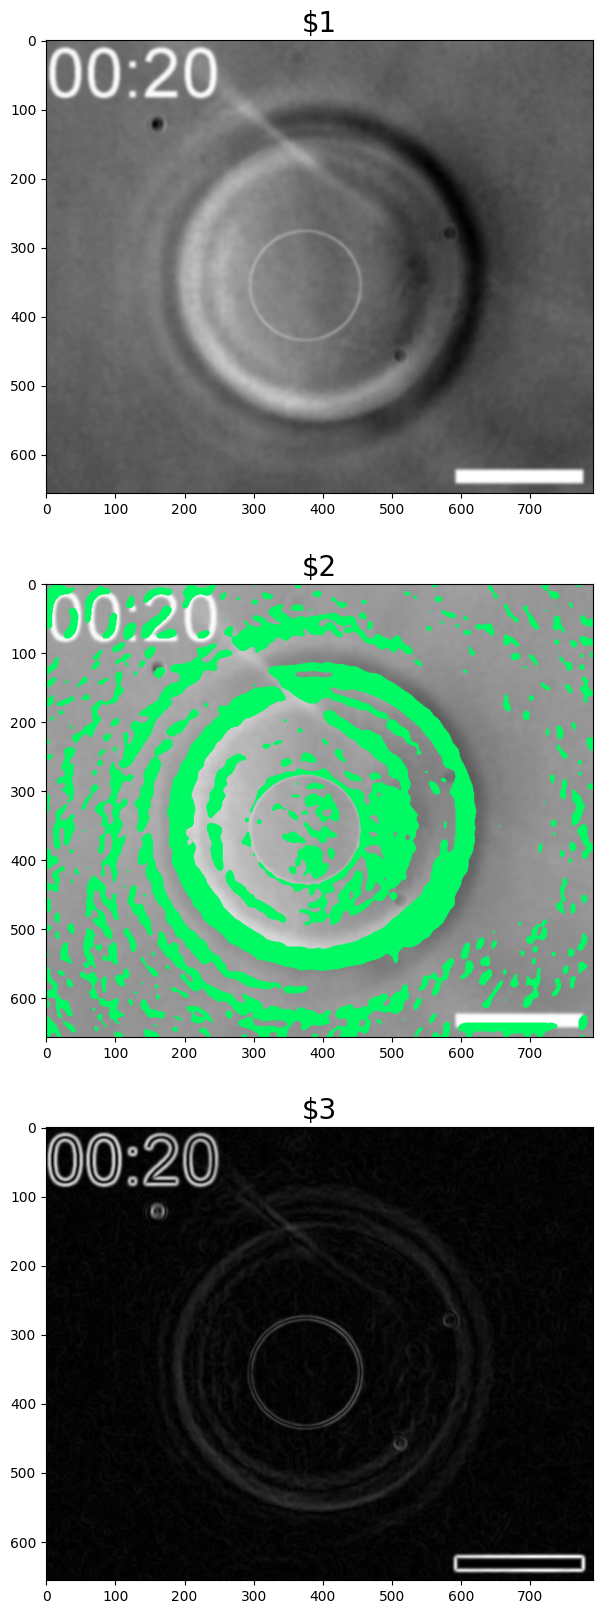

In [175]:
i = 20
tmp = color_images[i].copy()
tmp[masks[i] == 1] = [0, 250, 100]
display_images([source_images[i],tmp, data_list[i]], h=3)

-12981.498777654022 9308.408437371254


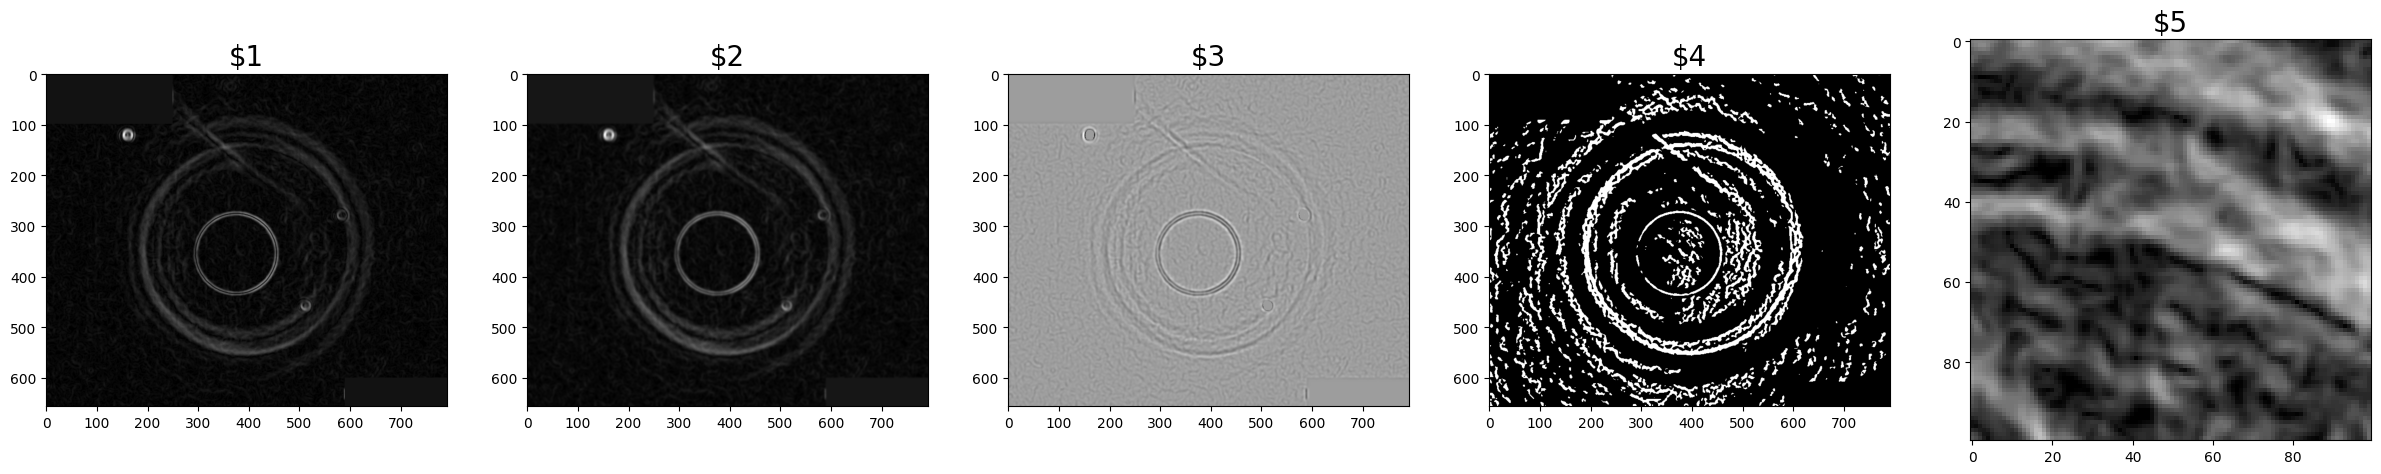

In [154]:
dust_mask = instance.dust_mask
d = data_list[i].copy()
d[:100, :250] = d[600:, 590:] = np.mean(d)
gauss = cv2.GaussianBlur(d, ksize=(7, 7), sigmaX=0, sigmaY=0)
lap = cv2.Laplacian(gauss, -1, ksize=5)
print(np.min(lap), np.max(lap))
buf = np.zeros(lap.shape)
lap = cv2.GaussianBlur(lap, ksize=(7, 7), sigmaX=0, sigmaY=0)
lap[dust_mask == 1] = np.mean(lap) * 0.8
thresh, binary = cv2.threshold((lap * masks[i]).astype('uint16'), 0, np.max(lap) * 2, cv2.THRESH_OTSU)
display_images([d, gauss, lap,  binary, d[100:200, 400:500]])

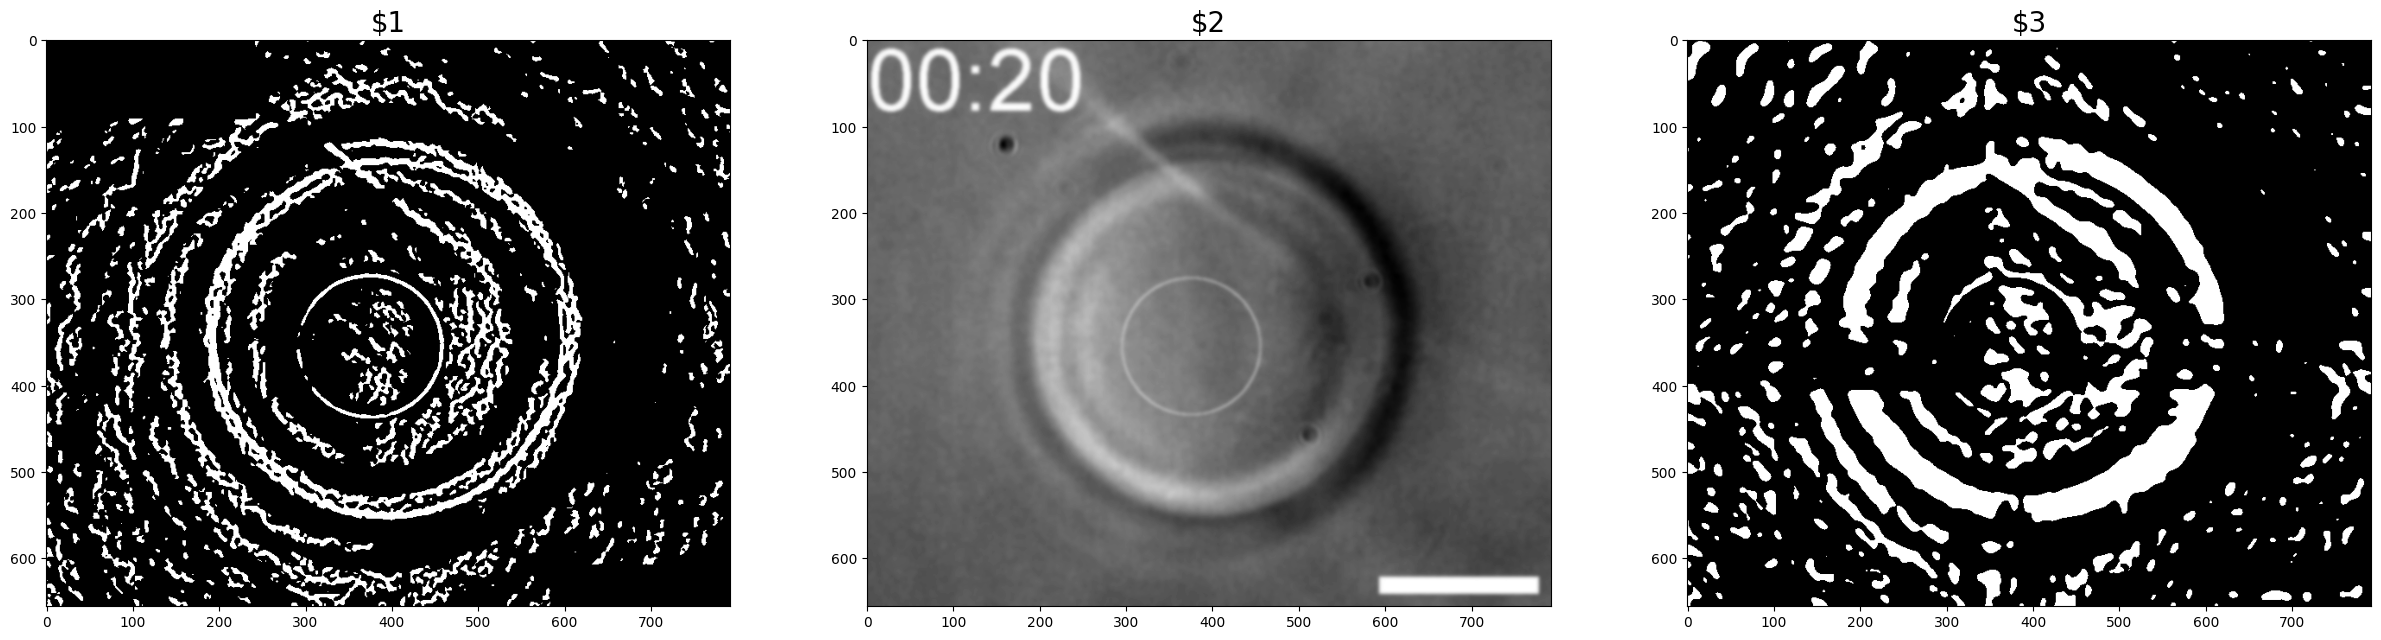

In [176]:
display_images([binary, instance.images[i], masks2[i]])

51

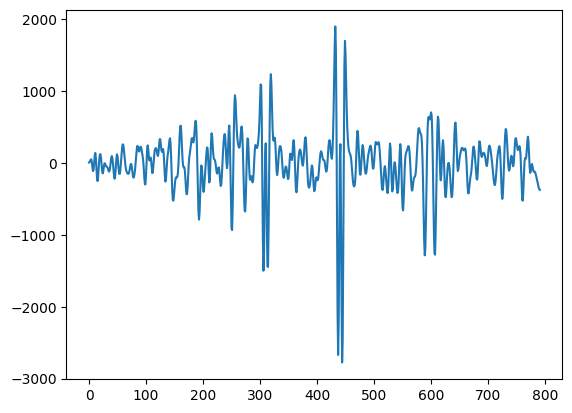

In [145]:
plt.plot(lap[400])

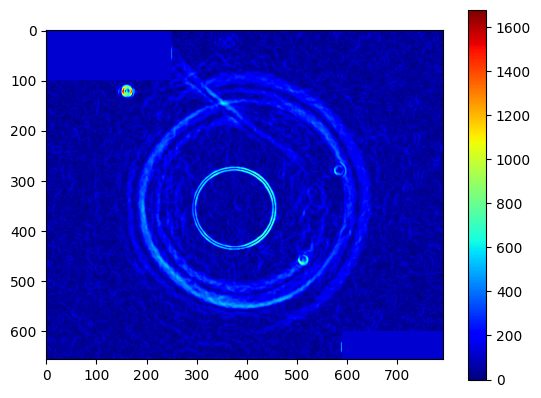

In [134]:
d2 = d.copy()
d2[d < 200] = 0
plt.imshow(d, cmap='jet')
plt.colorbar()

In [ ]:
"""
mask0: sensor dust
mask1: vector size > thresh
mask2: cos >= thresh
t: Laplacian(gaussianBlur(vector size image))
mask2(mask1(mask0(t)))


"""